In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from itertools import combinations
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
def BoxPlot(data_list, labels_list, figsize_tuple = (15, 5)):
    fig = plt.figure(num = 1, figsize = figsize_tuple)
    ax = fig.subplots()
    bplot = ax.boxplot(data_list,
                                 vert=True,  # vertical box alignment
                                 labels=labels_list)  # will be used to label x-ticks
    ax.set_xlabel('Digits used to train the sub-model')
    ax.set_ylabel('Uncertainties for recoginising other digits')
    plt.rcParams['figure.dpi'] = 150
    plt.show()

In [ ]:
def KL_loss(alpha, num_classes, device):
    unit = torch.ones([1, num_classes], dtype = torch.float32, device = device)
    S_alpha = torch.sum(alpha, dim = 1, keepdim = True)
    S_unit = torch.sum(unit, dim = 1, keepdim = True)
    lnA = torch.lgamma(S_alpha) - torch.sum(torch.lgamma(alpha), dim = 1, keepdim = True)
    lnU = torch.sum(torch.lgamma(unit), dim = 1, keepdim = True) - torch.lgamma(S_unit)
    
    digamma = torch.sum((alpha - 1) * (torch.digamma(alpha) - torch.digamma(S_alpha)), dim = 1, keepdim = True)
    
    KL_l = digamma +lnA + lnU
    
    return KL_l

def mse_loss(y, alpha):
    S = torch.sum(alpha, dim = 1, keepdim = True)
    
    loss_err = torch.sum((y - alpha / S) ** 2, dim = 1, keepdim = True)
    loss_var = torch.sum(alpha * (S - alpha) / (S * S * (S + 1)), dim = 1, keepdim = True)
    
    loss_all = loss_err + loss_var
    
    return loss_all

def EDL_loss(outputs, targets, epoch, num_classes, annealing_step):
    y = F.one_hot(targets, num_classes = num_classes).to(device)
    evidence = outputs.to(device)
    alpha = evidence + 1
    
    annealing_coef = torch.min(torch.tensor(1.0, dtype = torch.float32), torch.tensor(epoch / annealing_step, dtype = torch.float32))
    KL_alpha = (alpha - 1) * (1 - y) + 1
    KL_Loss = KL_loss(KL_alpha, num_classes, device)
    
    loss = mse_loss(y, alpha) + annealing_coef * KL_Loss
    
    mean_loss = torch.mean(loss)
    
    return mean_loss

In [ ]:
class LeNet(nn.Module):
    # define model elements
    def __init__(self, dim_image, num_classes, dropout=False):
        super().__init__()
        self.use_dropout = dropout
        self.conv1 = nn.Conv2d(1, 20, kernel_size = 5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size = 5)
        self.fc1 = nn.Linear(5000, 125)
        self.fc2 = nn.Linear(125, num_classes)
    
    # forward propagate input
    def forward(self, X):
        X = F.relu(self.conv1(X)) # Conv: dim_image - kernel_size + 1
        X = F.relu(F.max_pool2d(self.conv2(X), 2)) # Conv: dim_X - kernel_size + 1, max_pool: (dim_X - kernel_size + 1)/stride
        if self.use_dropout:
            X = F.dropout(X, p = 0.25, training = self.training)
        X = torch.flatten(X, 1) # dim_X ** 2 * 64
        X = F.relu(self.fc1(X))
        if self.use_dropout:
            X = F.dropout(X, training = self.training)
        X = F.relu(self.fc2(X))
        return X

class LeNet_EDL():
    def __init__(self, dim_image, num_epochs, num_classes, dropout = False, device = torch.device('cpu')):
        if not isinstance(dim_image, tuple) or len(dim_image) != 3:
            raise ValueError("The expected type of 'dim_image' is a tuple of (height, width, channels). Got {} with size of {}".format(type(dim_image), len(dim_image)))
        else:
            pass
        
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.device = device
        # define the model
        self.model = LeNet(dim_image, num_classes, dropout).to(device)
        # define the optimization
        self.loss_function = EDL_loss
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-3, weight_decay = 0.005)
        self.scheduler = StepLR(self.optimizer, step_size = 7, gamma = 0.1)
    
    def train(self, dataloader_train, epoch, verbose = True):
        self.model.train()
        correct = 0
        # enumerate mini batches
        for batch_idx, (inputs, targets) in enumerate(dataloader_train):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            # clear the gradients
            self.optimizer.zero_grad()
            # compute the model output
            outputs = self.model(inputs)
            # calculate loss
            loss = self.loss_function(outputs, targets, epoch, self.num_classes, 10)
            # credit assignment
            loss.backward()
            # update model weights
            self.optimizer.step()
            # calculate accuracy
            preds = outputs.argmax(dim = 1, keepdim = True)
            correct += preds.eq(targets.view_as(preds)).sum().item()
            # print train loss
            if verbose:
                if batch_idx % int(0.1*len(dataloader_train.dataset)/len(inputs)) == 0:
                    print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                            epoch, batch_idx * len(inputs), len(dataloader_train.dataset),
                            100. * batch_idx / len(dataloader_train), loss.item()))
        print('\nTrain set: Accuracy: {}/{} ({:.0f}%)'.format(
                correct, len(dataloader_train.dataset), 100. * correct / len(dataloader_train.dataset)))
    
    def test(self, dataloader_test, epoch):
        self.model.eval()
        loss, correct = 0, 0
        with torch.no_grad():
            for inputs, targets in dataloader_test:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                # compute the model output
                outputs = self.model(inputs)
                # calculate loss
                loss += self.loss_function(outputs, targets, epoch, self.num_classes, 10).sum()
                # calculate accuracy
                preds = outputs.argmax(dim = 1, keepdim = True)
                correct += preds.eq(targets.view_as(preds)).sum().item()
        loss /= len(dataloader_test.dataset)
        print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                loss, correct, len(dataloader_test.dataset),
                100. * correct / len(dataloader_test.dataset)))
    
    def fit(self, dataloader_train, dataloader_test):
        # enumerate epochs
        for epoch in range(1, self.num_epochs + 1):
            self.train(dataloader_train, epoch)
            self.test(dataloader_test, epoch)
            self.scheduler.step()
    
    def predict(self, dataloader):
        self.model.eval()
        predictions, actuals, probabilities, uncertainties = list(), list(), list(), list()
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                # evaluate the model on the dataset
                outputs = self.model(inputs)
                # retrieve numpy array
                outputs = outputs.detach().cpu().numpy()
                actual = targets.cpu().numpy()
                # convert to class labels
                prediction = np.argmax(outputs, axis=1)
                #print(prediction)
                # calculate probabilities and uncertainties
                evidence = outputs
                alpha = evidence + 1
                S = np.sum(alpha, axis = 1, keepdims = True)
                probability = alpha / S
                uncertainty = self.num_classes / S
                # reshape for stacking
                actual = actual.reshape((len(actual), 1))
                prediction = prediction.reshape((len(prediction), 1))
                probability = probability.reshape((len(probability), self.num_classes))
                uncertainty = uncertainty.reshape((len(uncertainty), 1))
                # store
                predictions.append(prediction)
                actuals.append(actual)
                probabilities.append(probability)
                uncertainties.append(uncertainty)
            predictions, actuals, probabilities, uncertainties = np.vstack(predictions), np.vstack(actuals), np.vstack(probabilities), np.vstack(uncertainties)
            # calculate accuracy
            acc = accuracy_score(actuals, predictions)
        return predictions, probabilities, uncertainties, acc

In [ ]:
# Model parameters
torch.manual_seed(1)
dim_image = (1, 28, 28)
num_epochs = 20
dropout = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare the dataset
transform=transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))])
data_train = datasets.MNIST("./data",
                            download=True,
                            train=True,
                            transform=transform)
data_test = datasets.MNIST("./data",
                           train=False,
                           download=True,
                           transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
combi_uncers = dict_uncers['[1, 2]']
combi_uncers.min()
combi_uncers.max()

count_0 = 0
count_25 = 0
count_50 = 0
count_75 = 0
for uncer in combi_uncers:
    if uncer > 0.75:
        count_75 += 1
    elif uncer > 0.5:
        count_50 += 1
    elif uncer > 0.25:
        count_25 += 1
    else:
        count_0 += 1
print('0<=uncer<=0.25: {}/{}'.format(count_0, len(combi_uncers)))
print('0.25<uncer<=0.5: {}/{}'.format(count_25, len(combi_uncers)))
print('0.5<uncer<=0.75: {}/{}'.format(count_50, len(combi_uncers)))
print('uncer>0.75: {}/{}'.format(count_75, len(combi_uncers)))

NameError: ignored

In [ ]:
def get_device():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda:0" if use_cuda else "cpu")
  return device

def test_minst_in_out_dist(in_dist, out_dist, unseen, edl_epochs, OODepochs, dropout, device=None):
  if not device:
    device = get_device()

  num_classes = len(in_dist)

  ID_digits_train = []
  ID_digits_test = []
  OOD_digits_train = []
  OOD_digits_test = []

  train_size = 2500 
  test_size = 500 

  id_num_samples = np.zeros(len(in_dist))
  ood_num_samples = np.zeros(len(out_dist))

  for i, (img, label) in enumerate(data_train):
    if label in in_dist and id_num_samples[in_dist.index(label)] < train_size:
      ID_digits_train.append((img, in_dist.index(label)))
      id_num_samples[in_dist.index(label)]+=1
    elif label in out_dist and ood_num_samples[out_dist.index(label)] < train_size:
      OOD_digits_train.append((img, label))
      ood_num_samples[out_dist.index(label)]+=1

  id_num_samples = np.zeros(len(in_dist))
  ood_num_samples = np.zeros(len(out_dist))

  for i, (img, label) in enumerate(data_test):
    if label in in_dist and id_num_samples[in_dist.index(label)] < test_size:
      ID_digits_test.append((img, in_dist.index(label)))
      id_num_samples[in_dist.index(label)]+=1
    elif label in out_dist and ood_num_samples[out_dist.index(label)] < test_size:
      OOD_digits_test.append((img, label))
      ood_num_samples[out_dist.index(label)]+=1

  dataloader_train = DataLoader(ID_digits_train, batch_size=500, shuffle=True)
  dataloader_test = DataLoader(ID_digits_test, batch_size=500)
  dataloader_OOD_train = DataLoader(OOD_digits_train, batch_size=500, shuffle=True)
  dataloader_OOD_test = DataLoader(OOD_digits_test, batch_size=500)

  model = LeNet_EDL(dim_image, edl_epochs, num_classes, dropout, device)

  model.fit(dataloader_train, dataloader_test)

  #remake dataloader_train and dataloader_OOD_train so I can get uncertainties (no shuffle)
  dataloader_train = DataLoader(ID_digits_train, batch_size=500)
  dataloader_OOD_train = DataLoader(OOD_digits_train, batch_size=500)
  
  ID_train_preds, ID_train_probs, ID_train_uncers, ID_train_accs = model.predict(dataloader_train)
  OOD_train_preds, OOD_train_probs, OOD_train_uncers, OOD_train_accs = model.predict(dataloader_OOD_train)

  ID_test_preds, ID_test_probs, ID_test_uncers, ID_test_accs = model.predict(dataloader_test)
  OOD_test_preds, OOD_test_probs, OOD_test_uncers, OOD_test_accs = model.predict(dataloader_OOD_test)

  #Graph this for different values like
  #get_uncern_averages(in_dist, out_dist, ID_digits_train, OOD_digits_train, ID_train_uncers, OOD_train_uncers)
  #get_uncern_averages(in_dist, out_dist, ID_digits_test, OOD_digits_test, ID_test_uncers, OOD_test_uncers)

  #Gen new training dataset with ID and OOD with Uncertainties
  #go back from numerical so can track
  ID_digits_train = convert_from_numerical(ID_digits_train, in_dist)
  ID_OOD_digits_train = ID_digits_train + OOD_digits_train
  ID_OOD_digits_uncers = np.concatenate((ID_train_uncers, OOD_train_uncers))
  ID_OOD_uncers_train = []
  for i in range(len(ID_OOD_digits_train)):
    ID_OOD_uncers_train.append((ID_OOD_digits_train[i][0], ID_OOD_digits_uncers[i]))

  dataloader_ID_OOD_uncers = DataLoader(ID_OOD_uncers_train, batch_size=500, shuffle=True)

  OODmodel = LeNetCustom(1)
  #Loss can be changed - crossentropy doesnt work 
  optimizer = torch.optim.Adam(OODmodel.parameters(), lr=1e-3, weight_decay=0.005)
  criterion = nn.MSELoss()

  OODmodel = train_new_model(OODepochs, OODmodel, dataloader_ID_OOD_uncers, optimizer, criterion, device)

  OODmodel.eval()

  #go back from numerical so can track
  ID_digits_test = convert_from_numerical(ID_digits_test, in_dist)

  ID_OOD_uncers_test = ID_digits_test + OOD_digits_test

  ID_OOD_digits_uncers = convert_to_list(ID_OOD_digits_uncers)
  act_averages, act_stds = plot_averages_graph(in_dist, out_dist, unseen, ID_OOD_digits_train, ID_OOD_digits_uncers, True)
  print(act_averages)
  print(act_stds)

  #traing on training set
  #then testing uncertainties generated

  #unseen
  count = np.zeros(len(unseen))
  for i, (img, label) in enumerate(data_test):
    if label in unseen and count[unseen.index(label)] < test_size:
      ID_OOD_uncers_test.append((img, label))
      count[unseen.index(label)]+=1

  dataloader_ID_OOD_uncers_test = DataLoader(ID_OOD_uncers_test, batch_size=500)

  out = []
  for i, (inputs, labels) in enumerate(dataloader_ID_OOD_uncers_test):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = OODmodel(inputs)
    for j in range(len(outputs)):
      out.append(outputs[j].item())

  out_dist = out_dist + unseen
  pred_averages, pred_stds = plot_averages_graph(in_dist, out_dist, unseen, ID_OOD_uncers_test, out, True)

  classes = in_dist + out_dist
  max_id_avg = 0
  min_ood_avg = 1
  for i in in_dist:
    if act_averages[in_dist.index(i)] > max_id_avg:
      max_id_avg = act_averages[in_dist.index(i)]
  for i in out_dist:
    if i not in unseen:
      if act_averages[out_dist.index(i) + len(in_dist)] < min_ood_avg:
        min_ood_avg = act_averages[out_dist.index(i) + len(in_dist)]

  threshold = (min_ood_avg + max_id_avg) / 2

  preds = []
  for i in range(len(ID_OOD_uncers_test)):
    if out[i] < threshold:
      preds.append(0)
    else:
      preds.append(1)

  print("Maximal ID Average Uncertainty =", max_id_avg)
  print("Minimal OOD Average Uncertainty =", min_ood_avg)
  print("Threshold = ", threshold)

  corrects = np.zeros(len(in_dist+out_dist))
  incorrects = np.zeros(len(in_dist+out_dist))

  classes = in_dist + out_dist
  for i in classes:
    for j in range(len(preds)):
      if ID_OOD_uncers_test[j][1] == i:
        if i in in_dist:
          incorrects[classes.index(i)]+=preds[j]
        else: 
          corrects[classes.index(i)]+=preds[j]

    if i in in_dist:
      corrects[classes.index(i)] = 500 - incorrects[classes.index(i)]
    else:
      incorrects[classes.index(i)] = 500 - corrects[classes.index(i)]
         
  print(corrects)
  print(incorrects) 

  new_testing=[]
  for i in range(len(preds)):
    if preds[i] == 0:
      new_testing.append(ID_OOD_uncers_test[i])

  new_testing = convert_to_numerical(new_testing, in_dist, out_dist)
  
  new_testing_loader = DataLoader(new_testing, batch_size=500)
  new_preds, new_probs, new_uncers, new_accs = model.predict(new_testing_loader)
  print(new_accs)

  plot_correct_preds(in_dist, out_dist, unseen, corrects, incorrects)

  return model, act_averages, act_stds, pred_averages, pred_stds

def plot_averages_graph(in_dist, out_dist, unseen, dataset, uncers, return_averages=False):
  classes = in_dist + out_dist

  averages = []
  stds = []

  for i in classes:
    k = 0
    l = 0
    arr = []
    for j in range(len(dataset)):
      if dataset[j][1] == i:
        if(torch.is_tensor(uncers[j])):
          arr.append(uncers[j].item())
          k+=uncers[j].item()
          l+=1
        else:
          arr.append(uncers[j])
          k+=uncers[j]
          l+=1
    if(torch.is_tensor(k) or torch.is_tensor(l)):
      averages.append((k/l)[0])
    else:
      averages.append((k/l))
    stds.append(np.std(np.array(arr)))
      
  plt.xticks(range(len(classes)), classes)
  plt.xlabel("Classes")
  plt.ylabel("Average uncertainty and standard deviation")
  c = []
  for i in classes:
    if i in in_dist:
      c.append('red')
    elif i in unseen:
      c.append('yellow')
    else:
      c.append('blue')
  plt.bar(range(len(classes)), averages, color=c)
  plt.bar(range(len(classes)), stds, color='cyan')
  plt.show()

  if return_averages:
    return averages, stds

def convert_from_numerical(dataset, in_dist):
  for i in range(len(dataset)):
    dataset[i] = (dataset[i][0], in_dist[dataset[i][1]])
  return dataset

def convert_to_numerical(dataset, in_dist, out_dist):
  for i in range(len(dataset)):
    if dataset[i][1] in in_dist:
      dataset[i] = (dataset[i][0], in_dist.index(dataset[i][1]))
    else:
      dataset[i] = (dataset[i][0], len(in_dist) + out_dist.index(dataset[i][1]))
  return dataset
    

def get_uncern_averages(in_dist, out_dist, id_test, ood_test, id_uncers, ood_uncers):
  classes = in_dist + out_dist

  averages = []
  for label in classes:
    k = 0
    l = 0
  
    if label in in_dist:
      for i in range(len(id_uncers)):
        if id_test[i][1] == j:
          k+=id_uncers[i]
          l+=1
      averages.append(k/l)

    else:
      for i in range(len(ood_uncers)):
        if ood_test[i][1] == label:
          k+=ood_uncers[i]
          l+=1
      averages.append(k/l)

  print(classes)
  print(averages)

#Get to work on GPU 
def train_new_model(num_epochs, model, uncern_train_loader, optimizer, criterion, device=None):
  if not device:
    device=get_device()

  model.to(device)
  model.train()
    
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch + 1, num_epochs))
    print("-" * 10)
    
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(uncern_train_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      torch.reshape(labels, (500, 1))
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * inputs.size(0)
        
      epoch_loss = running_loss / len(uncern_train_loader.dataset)

      print("Train loss: {:.4f}".format(epoch_loss))
  return model

def convert_to_list(dataset):
  l = []
  for i in range(len(dataset)):
    l.append(dataset[i][0])
  return l 

Epoch: 1 [0/12500 (0%)]	Loss: 0.930265
Epoch: 1 [1000/12500 (8%)]	Loss: 0.846909
Epoch: 1 [2000/12500 (16%)]	Loss: 0.764023
Epoch: 1 [3000/12500 (24%)]	Loss: 0.669536
Epoch: 1 [4000/12500 (32%)]	Loss: 0.585659
Epoch: 1 [5000/12500 (40%)]	Loss: 0.513260
Epoch: 1 [6000/12500 (48%)]	Loss: 0.457551
Epoch: 1 [7000/12500 (56%)]	Loss: 0.394963
Epoch: 1 [8000/12500 (64%)]	Loss: 0.345464
Epoch: 1 [9000/12500 (72%)]	Loss: 0.352904
Epoch: 1 [10000/12500 (80%)]	Loss: 0.291559
Epoch: 1 [11000/12500 (88%)]	Loss: 0.288047
Epoch: 1 [12000/12500 (96%)]	Loss: 0.274277

Train set: Accuracy: 9889/12500 (79%)
Test set: Average loss: 0.0005, Accuracy: 2267/2500 (91%)

Epoch: 2 [0/12500 (0%)]	Loss: 0.283552
Epoch: 2 [1000/12500 (8%)]	Loss: 0.285613
Epoch: 2 [2000/12500 (16%)]	Loss: 0.254117
Epoch: 2 [3000/12500 (24%)]	Loss: 0.262870
Epoch: 2 [4000/12500 (32%)]	Loss: 0.224430
Epoch: 2 [5000/12500 (40%)]	Loss: 0.244852
Epoch: 2 [6000/12500 (48%)]	Loss: 0.191973
Epoch: 2 [7000/12500 (56%)]	Loss: 0.230499
Epoch:

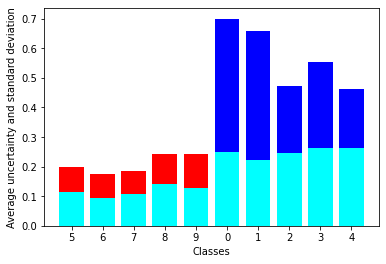

[0.19727721299231052, 0.1754052813321352, 0.1857707818955183, 0.2438633990585804, 0.24396362129449845, 0.6997293807089329, 0.6575195056557656, 0.47376755805313586, 0.5550637279808521, 0.4618702662050724]
[0.11299993, 0.093772784, 0.106354564, 0.14123595, 0.12700887, 0.2507669, 0.22136137, 0.24713512, 0.26313484, 0.26166946]


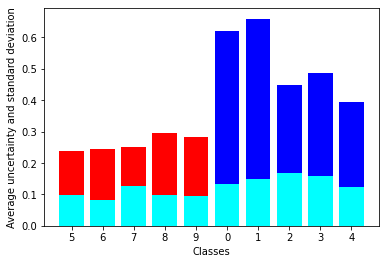

Maximal ID Average Uncertainty = 0.24396362129449845
Minimal OOD Average Uncertainty = 0.4618702662050724
Threshold =  0.35291694374978544
[445. 452. 414. 372. 393. 483. 491. 349. 382. 298.]
[ 55.  48.  86. 128. 107.  17.   9. 151. 118. 202.]
0.8002331908278274


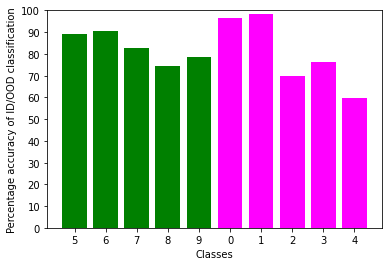

In [ ]:
model, act_averages, act_stds, pred_averages, pred_stds = test_minst_in_out_dist([5,6,7,8,9], [0,1,2,3,4], [], 20, 20, True)

In [ ]:
def plot_correct_preds(in_dist, out_dist, unseen, corrects, incorrects):
  classes = in_dist + out_dist
  percentages = []
  for i in range(len(corrects)):
    acc = (corrects[i] / (corrects[i]+incorrects[i])) * 100
    percentages.append(acc)

  yticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

  plt.xticks(range(len(classes)), classes)
  plt.yticks(yticks, yticks)

  plt.ylim(0,100)
  plt.xlabel("Classes")
  plt.ylabel("Percentage accuracy of ID/OOD classification")
  c = []
  for i in classes:
    if i in in_dist:
      c.append('green')
    elif i in unseen:
      c.append('yellow')
    else:
      c.append('magenta')
  plt.bar(range(len(classes)), percentages, color=c)
  plt.show()

In [ ]:
cycles = 2
in_dist = [1,2]
out_dist = [3,4]
act_av = [] 
act_std = []
pred_av = []
pred_std = []
model, act_av, act_std, pred_av, pred_std = test_minst_in_out_dist(in_dist, out_dist, 20, 20, True)
for i in range(cycles):
  model, a, b, c, d = test_minst_in_out_dist(in_dist, out_dist, 20, 20, True)
  act_av+=[sum(x) for x in zip(act_av, a)]
  act_std+=[sum(x) for x in zip(act_std, b)]
  pred_av+=[sum(x) for x in zip(pred_av, c)]
  pred_std+=[sum(x) for x in zip(pred_std, d)]
  
act_av_new = [x/cycles for x in act_av]
act_std_new = [x/cycles for x in act_std]
pred_av_new = [x/cycles for x in pred_av]
pred_std_new = [x/cycles for x in pred_std]

plot_graph_cycles(act_av_new, act_std_new, in_dist, out_dist)
plot_graph_cycles(pred_av_new, pred_std_new, in_dist, out_dist)

KeyboardInterrupt: ignored

In [ ]:
def plot_graph_cycles(av, std, in_dist, out_dist):
  classes = in_dist+out_dist
  plt.xticks(range(len(classes)), classes)
  plt.xlabel("Classes")
  plt.ylabel("Average pred uncertainty + standard deviation")
  c = []
  for i in classes:
    if i in in_dist:
      c.append('red')
  else:
    c.append('blue')
  plt.bar(range(len(classes)), av, color=c)
  plt.bar(range(len(classes)), std, color='cyan')
  plt.show()

TypeError: ignored

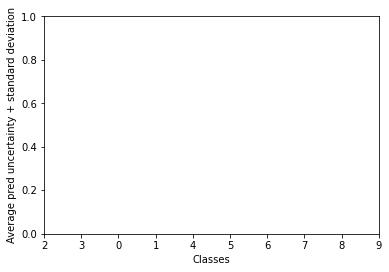

In [ ]:
predict_ood([2, 3], [0, 1, 4, 5, 6, 7, 8, 9], model)

In [ ]:
class LeNetCustom(nn.Module):
    def __init__(self, i, dropout=False):
        super().__init__()
        self.use_dropout = dropout
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.fc1 = nn.Linear(20000, 500)
        self.fc2 = nn.Linear(500, i)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 1))
        x = F.relu(F.max_pool2d(self.conv2(x), 1))
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
def plot_line_graphs():
  classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  labels = ["[0,1]", "[1,2]", "[2,3]", "[3,4]", "[4,5]", "[5,6]"]
  #avgs1 = [0.05833716673403978, 0.07675652301758527, 0.156055958686769, 0.21790843129903079, 0.16345146936774255, 0.1845883566096425, 0.13709165231585502, 0.18475149037837982, 0.1845632427677512, 0.191499869915843]
  avgs2 = [0.0959775234490633, 0.12133863112032413, 0.09061832044124603, 0.2455599723815918, 0.1841721373349428, 0.2566152766242623, 0.14015692297369242, 0.32383499072045085, 0.24519509212076665, 0.2039477029621601]
  avgs3 = [0.23754465886354448, 0.34837241730690005, 0.12307744940370322, 0.1291914856672287,  0.30324085128605366, 0.2046607456624508, 0.25392456237971783, 0.3421200760364532, 0.3018926462560892, 0.23766004881560804]
  avgs4 = [0.12051778936088085, 0.24073535447716712, 0.15864812661409378,0.08477134372293949, 0.09237765255123377,  0.1709922453612089, 0.2799498238399625, 0.21136666548997163, 0.1531814236342907, 0.20835029569268226]
  avgs5 = [0.11250053606033325, 0.21793065360486508, 0.17909004751741886, 0.12766357449889182,0.08684256047606469, 0.09600486880838871,  0.19733826861381532, 0.19731163069605828, 0.17713400455415249, 0.15229218156635763]
  avgs6 = [0.2752662995815277, 0.35093960970044136, 0.23972488929033278, 0.09546990830600262, 0.2334825700134039,0.10195549248158932, 0.11966588680297137,  0.10684667823314667, 0.171417072160542, 0.16127339923530817]

  plt.xticks(range(len(classes)), classes)
  plt.ylim(0, 0.5)

  #plt.plot(classes, avgs1, label = labels[0])
  #plt.plot(classes, avgs2, label = labels[1], color='magenta')
  plt.plot(classes, avgs3, label = labels[2], color = 'green')
  plt.plot(classes, avgs4, label = labels[3], color = 'red')
  plt.plot(classes, avgs5, label = labels[4], color = 'blue')
  plt.plot(classes, avgs6, label = labels[5], color = 'magenta')

  plt.legend()
  plt.show()

def plot_multiple_bars():
  classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
  labels = ["0, 1", "1, 2, 3, 4, 5", "2, 3, 4, 5, 6", "3, 4, 5, 6, 7", "4, 5, 6, 7, 8", "5, 6, 7, 8, 9"]
  #avgs1 = [0.05833716673403978, 0.07675652301758527, 0.156055958686769, 0.21790843129903079, 0.16345146936774255, 0.1845883566096425, 0.13709165231585502, 0.18475149037837982, 0.1845632427677512, 0.191499869915843]
  avgs2 = [0.5319879103720189, 0.19142128181457518, 0.20233016830086709, 0.21625802979171277, 0.15313777452409266, 0.170151992726326, 0.5805640898793936, 0.5459230298340321, 0.6927190712928772, 0.3794606766372919]
  avgs3 = [0.6867268070757389, 0.7125590759992599, 0.1942066028147936, 0.20966769264936447, 0.17028278628885746, 0.20518676962554455, 0.18186490958333015,  0.5587399311184883, 0.7938039035439491, 0.41959668526649474]
  avgs4 = [0.7626725357353688, 0.6985853087604046, 0.5004386360824108, 0.2024466936737299, 0.16459765290617942, 0.20122021961808204, 0.17534353420734405, 0.17836325015127658,  0.7528358616054058, 0.5981800002515316]
  avgs5 = [0.634814228707552, 0.7136356923282147, 0.41770597506761553, 0.41997582199275496,0.18861583248972894, 0.1833416085422039, 0.18825740847587585, 0.16095453687310218, 0.229401999899745,  0.548949811527133]
  avgs6 = [0.6997293807089329, 0.6575195056557656, 0.47376755805313586, 0.5550637279808521, 0.4618702662050724, 0.19727721299231052, 0.1754052813321352, 0.1857707818955183, 0.2438633990585804, 0.24396362129449845]



  stds1 = [0.0216647, 0.023100602, 0.08296993, 0.09805832, 0.09859829, 0.09778743, 0.078545384, 0.11030916, 0.08012412, 0.10817996]
  stds2 = [0.068657294, 0.052603543, 0.06540403, 0.17882185, 0.120477974, 0.19047332, 0.10724853, 0.21083772, 0.15410207, 0.13391884]
  stds3 = [0.25390995, 0.21494102, 0.10891795, 0.12538497, 0.08691435, 0.11798748, 0.09529594,  0.24873647, 0.23325966, 0.23560508]
  stds4 = [0.2617739, 0.23551165, 0.25706777, 0.12651543, 0.091517635, 0.1185048, 0.088655755, 0.11869464, 0.25280392, 0.26786715]
  stds5 = [0.26580653, 0.20877016, 0.22215334, 0.2046433,0.10330304, 0.10415454, 0.101541996, 0.09710703, 0.13225728,  0.24275701]
  stds6 = [0.2507669, 0.22136137, 0.24713512, 0.26313484, 0.26166946, 0.11299993, 0.093772784, 0.106354564, 0.14123595, 0.12700887]

  plt.xticks(range(len(classes)), classes)
  plt.ylim(0, 0.5)

  X_axis = np.arange(len(classes))

  plt.bar(X_axis - 0.3, stds3, 0.2, label = labels[2], color='blue')
  plt.bar(X_axis - 0.1, stds4, 0.2, label = labels[3], color='red')
  plt.bar(X_axis + 0.1, stds5, 0.2, label = labels[4], color='green')
  plt.bar(X_axis + 0.3, stds6, 0.2, label = labels[5], color='magenta')

  plt.xlabel("Classes")
  plt.ylabel("Uncertainty Standard Deviation")

  plt.legend()
  plt.show()


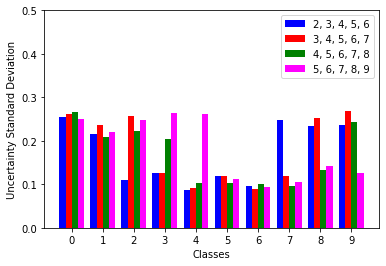

In [ ]:
#plot_line_graphs()
plot_multiple_bars()